# **CamemBERT**

[CamemBERT](https://camembert-model.fr/) est un modèle de traitement automatique de la langue Française, basé sur l'architecture [RoBERTa](https://ai.facebook.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/) développée par Facebook AI en 2019, dédiée à l'Anglais. RoBERTa est lui même basé sur [BERT](https://fr.wikipedia.org/wiki/BERT_(mod%C3%A8le_de_langage)) qui a été développé par Google en 2018.  
CamemBERT est donc un cousin Français de BERT, qui a pu voir le jour lorsque les équipes de Facebook associés aux chercheurs de [l'INRIA](https://www.inria.fr/fr) ont rendu public ce modèle pré-entrainé sur 138GB de texte Français.  
CamemBERT a été pré-entraîné sur un corpus francophone et avec des hyper-paramètres différents découverts et testés pour la première fois par l’équipe de Facebook. Le choix de ces hyper-paramètres était tellement réussi que l’entreprise a annoncé le sortie d’un “nouveau” modèle baptisé RoBERTa. Pourtant, il n’y a rien de nouveau dans RoBERTA qui comme CamemBERT reste une copie de BERT. Voici ces hyper-paramètres:  
*  CamemBERT choisit les mots à prédire de manière dynamique, c’est-à-dire, non pas lors du pré-processing des données en entrée, mais lors de forward pass, en masquant au hasard certains mots d’une séquence.  
*  Il utilise un batch size différent: ~8 000 contre 256 dans le cas de BERT.  
*  CamemBERT a un seul objectif de pré-entrainement: prédiction des “mots masqués” d’une séquence. BERT en avait deux : prédiction des “mots masqués” et de la phrase suivante d’une séquence. Ce dernier objectif s’est avéré improductif pour l’entrainement.

# **Exemple d'utlisation de CamemBERT**

CamemBERT a été entrainé dans le but de prédire des "mots masqués" dans un texte. Nous allons voir un exemple de ce que peut faire ce modèle pré-entrainé.

In [ ]:
Commençons par installer sur la machine les modules python dont nous aurons besoin et qui ne sont pas pré-installés :

In [3]:
!pip install transformers --quiet

     |████████████████████████████████| 890kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 14.7MB/s 
     |████████████████████████████████| 3.0MB 17.3MB/s 
     |████████████████████████████████| 890kB 33.4MB/s 


In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from transformers import TFCamembertModel
from transformers.tokenization_camembert import CamembertTokenizer

import matplotlib.pyplot as plt

import random

In [92]:
phrase = "Le camembert est <mask>"
output_tokenizer = tokenizer.encode_plus(phrase, max_length=100, padding="longest", truncation=True)
print(output_tokenizer)

{'input_ids': [5, 16, 730, 25543, 110, 30, 32004, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [24]:
from transformers import TFCamembertForMaskedLM
from transformers.tokenization_camembert import CamembertTokenizer

model = TFCamembertForMaskedLM.from_pretrained("jplu/tf-camembert-base")

All model checkpoint weights were used when initializing TFCamembertForMaskedLM.

All the weights of TFCamembertForMaskedLM were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForMaskedLM for predictions without further training.


In [19]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('jplu/tf-camembert-base')


In [59]:
phrase = "Le camembert est un <mask>"
output_tokenizer = tokenizer.encode_plus(phrase, max_length=100, padding="longest", truncation=True, return_tensors='tf')
print(output_tokenizer)

{'input_ids': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=
array([[    5,    54,   730, 25543,   110,    30,    23, 32004,     6]],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [60]:
mask_index = (output_tokenizer['input_ids'][0].numpy() == tokenizer.mask_token_id).nonzero()
mask_index = np.reshape(mask_index,(1))[0]
mask_index

7

In [22]:
np.reshape(mask_index,(1))[0]

6

In [61]:
output = model(output_tokenizer['input_ids'])[0]
output

<tf.Tensor: shape=(1, 9, 32005), dtype=float32, numpy=
array([[[ 19.751926  ,  -4.4060893 ,   6.014935  , ...,  -6.5229745 ,
          -2.7044492 ,   0.77759504],
        [  1.3340726 ,  -4.854663  ,  15.988392  , ..., -13.964043  ,
          -2.6400814 ,   0.05368042],
        [ -0.18725157,  -9.38402   ,   2.3775923 , ..., -22.591091  ,
         -11.347634  ,  -2.9210095 ],
        ...,
        [ -0.79850745,  -7.241239  ,   5.3250237 , ..., -13.265451  ,
          -7.970719  ,  -3.208213  ],
        [ -0.73735166,  -4.438918  ,   5.1624565 , ..., -14.27537   ,
          -5.222227  ,  -5.2601447 ],
        [  3.7182884 ,  -5.7987967 ,  22.753208  , ...,  -9.456286  ,
          -4.837267  ,   1.5808692 ]]], dtype=float32)>

In [62]:
output  = output[0, masked_index, :]
output

<tf.Tensor: shape=(32005,), dtype=float32, numpy=
array([ -0.73735166,  -4.438918  ,   5.1624565 , ..., -14.27537   ,
        -5.222227  ,  -5.2601447 ], dtype=float32)>

In [63]:
proba = tf.nn.softmax(output)
proba

<tf.Tensor: shape=(32005,), dtype=float32, numpy=
array([1.6085463e-07, 3.9706713e-09, 5.8706690e-05, ..., 2.1229854e-13,
       1.8141652e-09, 1.7466634e-09], dtype=float32)>

In [74]:
top_proba, top_indices = tf.math.top_k(proba,k=10)
print(top_proba)
print(top_indices)

tf.Tensor(
[0.2314386  0.18368356 0.1775473  0.10596294 0.04635359 0.04131484
 0.0188485  0.01474777 0.01201454 0.01196567], shape=(10,), dtype=float32)
tf.Tensor([  186  5271   807   501  1583 10586  3735  6432 24885  4179], shape=(10,), dtype=int32)


In [75]:
topk_predicted_token_bpe2 = " ".join([tokenizer.convert_ids_to_tokens(int(tf.keras.backend.get_value(top_indices[i]))) for i in range(len(top_indices))])
topk_predicted_token_bpe2 

'▁... ▁fromage ▁[...] ▁produit ▁(...) ▁aliment ▁fruit ▁dessert ▁légume ▁poisson'

In [76]:
mask = tokenizer.mask_token
mask

'<mask>'

In [92]:
topk_predicted_token_bpe2.split(" ")

['▁...',
 '▁fromage',
 '▁[...]',
 '▁produit',
 '▁(...)',
 '▁aliment',
 '▁fruit',
 '▁dessert',
 '▁légume',
 '▁poisson']

In [99]:
topk_filled_outputs_ = []
for index2, predicted_token_bpe2 in enumerate(topk_predicted_token_bpe2.split(" ")):
  predicted_token_ = predicted_token_bpe2.replace("\u2581", " ")
  if " {0}".format(tokenizer.mask_token) in phrase:
    topk_filled_outputs_.append((phrase.replace(" {0}".format(tokenizer.mask_token), predicted_token_)))
  else:
    topk_filled_outputs_.append((phrase.replace(tokenizer.mask_token, predicted_token_)))

topk_filled_outputs_

['Le camembert est un ...',
 'Le camembert est un fromage',
 'Le camembert est un [...]',
 'Le camembert est un produit',
 'Le camembert est un (...)',
 'Le camembert est un aliment',
 'Le camembert est un fruit',
 'Le camembert est un dessert',
 'Le camembert est un légume',
 'Le camembert est un poisson']

--------------------------------------------------------------------------------------------

In [23]:
Camembert = TFCamembertModel.from_pretrained("jplu/tf-camembert-base")

Some weights of the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [37]:


tokenizer = CamembertTokenizer.from_pretrained("camembert-base",do_lower_case=True)

phrase = "L'intelligence artificielle va créer la <mask> du monde"





{'input_ids': [5, 17, 11, 6031, 7956, 198, 739, 13, 32004, 25, 164, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [35]:
input_ids_train = np.array(select_field(output, 'input_ids'))
attention_masks_train = np.array(select_field(output, 'attention_mask'))
Camembert.predict(input_ids_train)

TypeError: ignored

# Training Data

Download labeled data from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

In [6]:
# Téléchargement des données depuis le repot github "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2"

!wget -q "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2"
!tar -xjvf data.tar.bz2

data/
data/allocine_dataset.pickle
data/test.jsonl
data/train.jsonl
data/val.jsonl


In [3]:
DataEntrainement = pd.read_json("/content/data/test.jsonl", lines=True)
DataEntrainement.head(5)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-25385/cr...,"Magnifique épopée, une belle histoire, touchan...",1
1,http://www.allocine.fr/film/fichefilm-1954/cri...,Je n'ai pas aimé mais pourtant je lui mets 2 é...,0
2,http://www.allocine.fr/film/fichefilm-135523/c...,Un dessin animé qui brille par sa féerie et se...,1
3,http://www.allocine.fr/film/fichefilm-61514/cr...,"Si c'est là le renouveau du cinéma français, c...",0
4,http://www.allocine.fr/film/fichefilm-260395/c...,Et pourtant on s’en Doutait !Second volet très...,0






# Data Preparation

In [4]:
MAX_SEQUENCE_LENGTH = 500

# Chargement des commentaires et des ressentis
commentaires = DataEntrainement['review'].astype(str).tolist()      # Récupère tous les commentaires dans une liste python
ressentis = DataEntrainement['polarity'].tolist()                   # Récupère tous les ressentis dans une liste python
labels = np.asarray(ressentis)                                      # Créé un tableau de type numpy avec les ressentis

x_entrainement, x_test, y_entrainement, y_test = train_test_split(commentaires, labels, test_size=0.2)

In [11]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base",do_lower_case=True)

def to_tokens(input_text, tokenizer):
    x = input_text['commentaire'].astype(str).tolist()
    output = tokenizer.encode_plus(x, max_length=MAX_SEQUENCE_LENGTH, padding="longest", truncation=True)
    return output

def to_tokens2(input_text, tokenizer):
    x = input_text['commentaire'].astype(str).tolist()
 #   print(input_text)
    #output = tokenizer.encode_plus(input_text, max_length=MAX_SEQUENCE_LENGTH, padding="longest", truncation=True)
#    return output


def select_field(features, field):
    return [feature[field] for feature in features]

In [18]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base",do_lower_case=True)

x = x_entrainement[0]
output = tokenizer.encode_plus("Bonjour à [MASK]", max_length=MAX_SEQUENCE_LENGTH, padding="longest", truncation=True)
output

{'input_ids': [5, 5061, 15, 403, 4720, 496, 374, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
x = pd.DataFrame(x_entrainement,columns=['commentaire'])
#x = x['commentaire'].astype(str).tolist()
#x
#tokenizer.encode_plus(x,max_length=MAX_SEQUENCE_LENGTH, padding="longest", truncation=True)

tokenizer_output_train = x.apply(lambda x: to_tokens2(x, tokenizer))
#tokenizer_output_test = (pd.DataFrame(x_test)).apply(lambda x: to_tokens(x, tokenizer))


KeyError: ignored

In [ ]:
input_ids_train = np.array(select_field(tokenizer_output_train, 'input_ids'))
#attention_masks_train = np.array(select_field(tokenizer_output_train, 'attention_mask'))

#input_ids_test = np.array(select_field(tokenizer_output_test, 'input_ids'))
#attention_masks_test = np.array(select_field(tokenizer_output_test, 'attention_mask'))

TypeError: ignored

# Define Model

In [ ]:
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
attention_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
x = TFCamembertModel.from_pretrained("jplu/tf-camembert-base")(inputs=text_input, attention_mask=attention_input)[1]

Some weights of the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [ ]:
inputs = [text_input, attention_input]
z = Dense(200, activation="relu")(x)
z = Dropout(0.2)(z)
output = Dense(2, activation='softmax')(z)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_words")

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_segment_ids])

l1 = Lambda(lambda seq: seq[:, 0, :])(sequence_output)
output = Dense(2, activation='softmax')(l1)
model = Model([input_word_ids, input_mask, input_segment_ids], output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

# Transfer Learning

BERT layer weights/biases are frozen, only train the final dense layer.

In [ ]:
history = model.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Epoch 1/5
732/732 [==============================] - 36s 49ms/step - loss: 0.3773 - accuracy: 0.8496 - val_loss: 0.2810 - val_accuracy: 0.8907
Epoch 2/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2417 - accuracy: 0.9139 - val_loss: 0.2540 - val_accuracy: 0.8889
Epoch 3/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2150 - accuracy: 0.9248 - val_loss: 0.2608 - val_accuracy: 0.8871
Epoch 4/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2016 - accuracy: 0.9216 - val_loss: 0.2531 - val_accuracy: 0.9035
Epoch 5/5
732/732 [==============================] - 34s 47ms/step - loss: 0.1913 - accuracy: 0.9294 - val_loss: 0.2463 - val_accuracy: 0.8998


# Fine Tuning

Unfreeze BERT layer, choose lower learning rate and retrain all layers.

In [ ]:
bert_layer.trainable = True
output.trainable = False
model2 = Model([input_word_ids, input_mask, input_segment_ids], output)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
history2 = model2.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Epoch 1/5
732/732 [==============================] - 111s 151ms/step - loss: 0.1961 - accuracy: 0.9275 - val_loss: 0.1467 - val_accuracy: 0.9472
Epoch 2/5
732/732 [==============================] - 109s 149ms/step - loss: 0.0209 - accuracy: 0.9932 - val_loss: 0.2696 - val_accuracy: 0.9381
Epoch 3/5
732/732 [==============================] - 110s 150ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.2351 - val_accuracy: 0.9344
Epoch 4/5
732/732 [==============================] - 110s 150ms/step - loss: 7.8046e-04 - accuracy: 1.0000 - val_loss: 0.3164 - val_accuracy: 0.9472
Epoch 5/5
732/732 [==============================] - 109s 149ms/step - loss: 0.0125 - accuracy: 0.9986 - val_loss: 0.2628 - val_accuracy: 0.9399


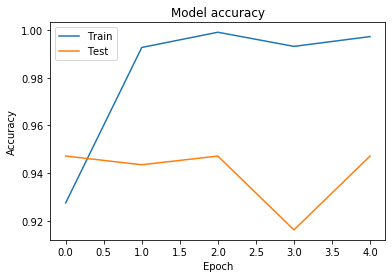

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predictions

In [ ]:
predictions = model2.predict(encodeText(x_test))
most_likely = predictions.argmax(1)

In [ ]:
index = random.randrange(len(predictions))
print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

I really loved the story line and the poler bear was kinda cute.But if anyone has a question about Fort Steele, just ask away:)  
Prediction: 1, label: 1


# Error Analysis

The Veggitarian platter is out of this world!
Prediction: 0, label: 1


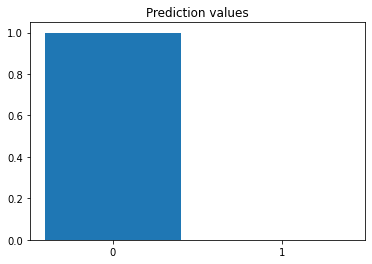

In [ ]:
for i in range(1000):
    index = random.randrange(len(predictions))
    if most_likely[index] != y_test[index]:
        break

print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

plt.bar(range(2), predictions[index], tick_label=range(2))
plt.title('Prediction values')
plt.show()

In [ ]:
text = []
labels = []
preds = []
for i in range(len(predictions)):
  if most_likely[i] != y_test[i]:
    text.append(x_test[i])
    labels.append(y_test[i])
    preds.append(most_likely[i])

errors = pd.DataFrame({'Comment':text, 'Sentiment':labels, 'Predictions':preds})
errors.head()

,Comment,Sentiment,Predictions
0,It definitely was not as good as my S11.,1,0
1,For a product that costs as much as this one d...,0,1
2,You get extra minutes so that you can carry ou...,1,0
3,This place deserves one star and 90% has to do...,0,1
4,I'm not really sure how Joey's was voted best ...,0,1
